### Importing the Libraries and Installing the Packages

In [15]:
import nltk
import json
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import random
from sklearn.model_selection import train_test_split
!pip install torchviz

### Downloading NLP Packages

In [16]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ritur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ritur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Processing Data 

In [17]:
stemmer = WordNetLemmatizer()

words = []
classes = []
documents = []
ignore_words = ['?']

# Read intents from the JSON file
with open('../Dataset/University_Data.json', 'r') as file:
    intents = json.load(file)

for intent in intents['intents']:
    for pattern in intent['patterns']:
        # Tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # Add to our words list
        words.extend(w)
        # Add to documents in our corpus
        documents.append((w, intent['tag']))
        # Add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])


words = [stemmer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))


classes = sorted(list(set(classes)))

print(len(documents), "documents")
print(len(classes), "classes", classes)
print(len(words), "Lemmatized words", words)

825 documents
42 classes ['Accelerated-Honors-JD-Program', 'Athletic-Training', 'Audiology', 'Bias-Response--Reporting', 'CSO', 'Clinical-Nutrition', 'DDS-Admissions', 'Everything-you-need-to-know-about-New-Student-and-Family-Orientation---People-of-Pacific', 'Experiential-Curriculum', 'Homecoming-and-Family-Weekend', 'IDS-Application-Requirements--University-of-the-Pacific', 'International-Students', 'JD-Program', 'LLM--JSD', 'LoanRelated', 'MS-SpeechLanguage-Pathology', 'MSL', 'Nursing', 'OLLI', 'Occupational-Therapy', 'PacificCard', 'Parking', 'Powell', "Questions-we-know-you're-asking---People-of-Pacific", 'Sacramento-Housing', 'Social-Work', 'Stockton-Housing', 'Sustainability-Fair--Clothing-Swap--University-of-the-Pacific', 'Transfer-Admission-Agreement', 'University-of-the-Pacific', 'Veterans', 'Yellow-Ribbon-Program', 'co-op_program', 'courses', 'creator', 'farewell', 'fees', 'financial aid and scholarships', 'greeting', 'hours', 'identity', 'summer_jobs']
1021 Lemmatized words

In [18]:
training = []
output = []
output_empty = [0] * len(classes)

# Training set, bag of words for each sentence
for doc in documents:
    # Initialize our bag of words
    bag = []
    # List of tokenized words for the pattern
    pattern_words = doc[0]
    # Lemmatize each word
    pattern_words = [stemmer.lemmatize(word.lower()) for word in pattern_words]
    # Create our bag of words arrays
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # Output is a '0' for each tag and '1' for the current tag
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
random.shuffle(training)
def synonym_replacement(tokens, limit):
    augmented_sentences = []
    for i in range(len(tokens)):
        synonyms = []
        for syn in wordnet.synsets(tokens[i]):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
        if len(synonyms) > 0:
            num_augmentations = min(limit, len(synonyms))
            sampled_synonyms = random.sample(synonyms, num_augmentations)
            for synonym in sampled_synonyms:
                augmented_tokens = tokens[:i] + [synonym] + tokens[i + 1:]
                augmented_sentences.append(' '.join(augmented_tokens))
    return augmented_sentences


# Augment the training data using synonym replacement
augmented_data = []
limit_per_tag = 100

for i, doc in enumerate(training):
    bag, output_row = doc
    tokens = [words[j] for j in range(len(words)) if bag[j] == 1]
    augmented_sentences = synonym_replacement(tokens, limit_per_tag)
    for augmented_sentence in augmented_sentences:
        augmented_bag = [1 if augmented_sentence.find(word) >= 0 else 0 for word in words]
        augmented_data.append([augmented_bag, output_row])

# Convert training and augmented_data to NumPy arrays
training_array = np.array(training, dtype=object)
augmented_data_array = np.array(augmented_data, dtype=object)

# Concatenate the arrays
combined_data = np.concatenate((training_array, augmented_data_array), axis=0)

# Shuffle the combined data
np.random.shuffle(combined_data)

### Splitting the Training and Test Dataset

In [19]:
def separate_data_by_tags(data):
    data_by_tags = {}
    for d in data:
        tag = tuple(d[1])
        if tag not in data_by_tags:
            data_by_tags[tag] = []
        data_by_tags[tag].append(d)
    return data_by_tags.values()


separated_data = separate_data_by_tags(combined_data)

# Lists to store training and testing data
training_data = []
testing_data = []

# Split each tag's data into training and testing sets
for tag_data in separated_data:
    train_data, test_data = train_test_split(tag_data, test_size=0.2, random_state=42)
    training_data.extend(train_data)
    testing_data.extend(test_data)
random.shuffle(training_data)
random.shuffle(testing_data)

# Convert training and testing data back to np.array
train_x = np.array([d[0] for d in training_data])
train_y = np.array([d[1] for d in training_data])
test_x = np.array([d[0] for d in testing_data])
test_y = np.array([d[1] for d in testing_data])

### Training the chatbot Model

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        output = self.softmax(x)
        return output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def accuracy(predictions, targets):
    predicted_labels = torch.argmax(predictions, dim=1)
    true_labels = torch.argmax(targets, dim=1)
    correct = (predicted_labels == true_labels).sum().item()
    total = targets.size(0)
    return correct / total

def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = len(test_loader)

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            total_accuracy += accuracy(outputs, targets) * inputs.size(0)

    average_loss = total_loss / len(test_loader.dataset)
    average_accuracy = total_accuracy / len(test_loader.dataset)
    return average_loss, average_accuracy

In [21]:
# Create DataLoader for training and testing data
train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
test_x = torch.tensor(test_x).float()
test_y = torch.tensor(test_y).float()

batch_size = 100 
train_dataset = CustomDataset(train_x, train_y)
test_dataset = CustomDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
input_size = len(train_x[0])
hidden_size = 8
output_size = len(train_y[0])
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Lists to store training and testing loss values
train_losses = []
test_losses = []

# Lists to store training and testing accuracy values
train_accuracies = []
test_accuracies = []

# Train the model and evaluate on the testing set
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * inputs.size(0)
        running_acc += accuracy(outputs, targets) * inputs.size(0)

    # Calculate average training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_acc / len(train_loader.dataset)

    # Store training loss and accuracy for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Print training loss and accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    # Evaluate on the testing set
    test_loss, test_accuracy = test_model(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'model.pth')

Epoch [1/100], Training Loss: 0.0571, Training Accuracy: 0.5263
Epoch [1/100], Testing Loss: 0.0252, Testing Accuracy: 0.8225
Epoch [2/100], Training Loss: 0.0182, Training Accuracy: 0.8629
Epoch [2/100], Testing Loss: 0.0142, Testing Accuracy: 0.8829
Epoch [3/100], Training Loss: 0.0125, Training Accuracy: 0.8944
Epoch [3/100], Testing Loss: 0.0113, Testing Accuracy: 0.9004
Epoch [4/100], Training Loss: 0.0104, Training Accuracy: 0.9080
Epoch [4/100], Testing Loss: 0.0100, Testing Accuracy: 0.9115
Epoch [5/100], Training Loss: 0.0092, Training Accuracy: 0.9162
Epoch [5/100], Testing Loss: 0.0090, Testing Accuracy: 0.9166
Epoch [6/100], Training Loss: 0.0084, Training Accuracy: 0.9214
Epoch [6/100], Testing Loss: 0.0083, Testing Accuracy: 0.9209
Epoch [7/100], Training Loss: 0.0079, Training Accuracy: 0.9247
Epoch [7/100], Testing Loss: 0.0078, Testing Accuracy: 0.9237
Epoch [8/100], Training Loss: 0.0075, Training Accuracy: 0.9267
Epoch [8/100], Testing Loss: 0.0077, Testing Accuracy:

# Model Inference

In [22]:
def load_model(model_path, input_size, hidden_size, output_size):
    model = NeuralNetwork(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to preprocess the input sentence
def preprocess_sentence(sentence, words):
    sentence_words = sentence.lower().split()
    sentence_words = [word for word in sentence_words if word in words]
    return sentence_words

# Function to convert the preprocessed sentence into a feature vector
def sentence_to_features(sentence_words, words):
    features = [1 if word in sentence_words else 0 for word in words]
    return torch.tensor(features).float().unsqueeze(0)

# Function to generate a response using the trained model
def generate_response(sentence, model, words, classes):
    sentence_words = preprocess_sentence(sentence, words)
    if len(sentence_words) == 0:
        return "I'm sorry, but I don't understand. Can you please rephrase or provide more information?"

    features = sentence_to_features(sentence_words, words)
    with torch.no_grad():
        outputs = model(features)

    probabilities, predicted_class = torch.max(outputs, dim=1)
    confidence = probabilities.item()
    predicted_tag = classes[predicted_class.item()]
    
    print(probabilities, predicted_class, confidence, predicted_tag)

    if confidence > 0.5:
        for intent in intents['intents']:
            if intent['tag'] == predicted_tag:
                return random.choice(intent['responses'])

    return "I'm sorry, but I'm not sure how to respond to that."

In [23]:
# Assuming your model is named 'model'
model.eval()

# Convert your X_train and X_test to PyTorch tensors
X_train_tensor = torch.tensor(train_x).float()
X_test_tensor = torch.tensor(test_x).float()

# Convert your y_train and y_test to PyTorch tensors
y_train_tensor = torch.tensor(train_y).float()
y_test_tensor = torch.tensor(test_y).float()

# Get predictions for training set
with torch.no_grad():
    outputs_train = model(X_train_tensor)

# Get predictions for testing set
with torch.no_grad():
    outputs_test = model(X_test_tensor)

# Calculate accuracy for training set
accuracy_train = accuracy(outputs_train, y_train_tensor)

# Calculate accuracy for testing set
accuracy_test = accuracy(outputs_test, y_test_tensor)

print("Training Accuracy: {:.4f}".format(accuracy_train))
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

# Print model summary
print(model)


Training Accuracy: 0.9413
Testing Accuracy:  0.9321
NeuralNetwork(
  (fc1): Linear(in_features=1021, out_features=8, bias=True)
  (relu1): ReLU()
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (relu2): ReLU()
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=8, out_features=42, bias=True)
  (softmax): Softmax(dim=1)
)


In [24]:
from keras.backend import clear_session
# clear states generated by Keras to reduce memory usage
clear_session()

In [25]:
from torchviz import make_dot

# Assuming your PyTorch model is named 'model'
dummy_input = torch.randn(1, input_size)  # Adjust the shape as per your input size

# Create a dummy input tensor for visualization
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save the visualization to a file (e.g., PNG)
dot.render("model_visualization", format="png", cleanup=True)


'model_visualization.png'

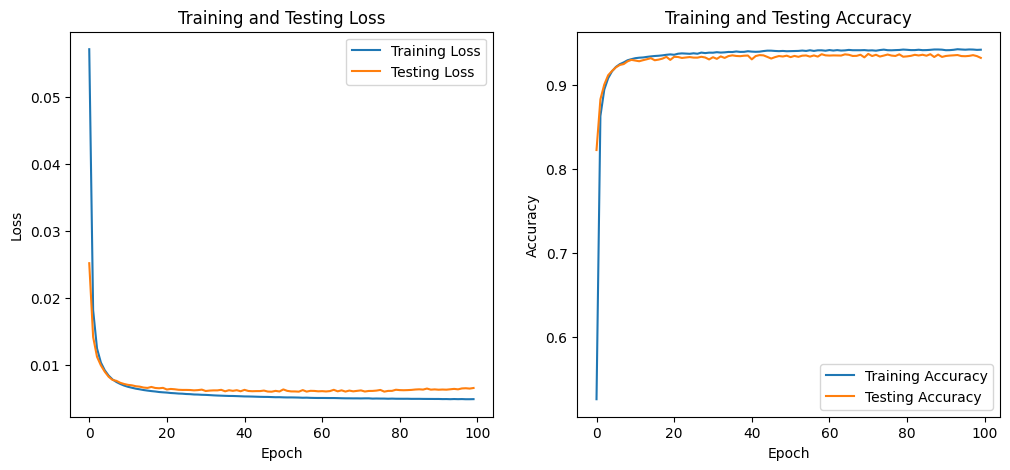

In [26]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
import sys
model_path = 'model.pth'
input_size = len(words)
hidden_size = 8
output_size = len(classes)
model = load_model(model_path, input_size, hidden_size, output_size)

print('Hello! I am a chatbot. How can I help you today? Type "quit" to exit.')
while True:
    sys.stdout.flush()  # Flush the standard output
    user_input = input('> ')
    sys.stdin.flush()   # Flush the standard input
    if user_input.lower() == 'quit':
        break
    response = generate_response(user_input, model, words, classes)
    print(response)
    sys.stdout.flush()  # Flush the standard output again

Hello! I am a chatbot. How can I help you today? Type "quit" to exit.


In [28]:
import textwrap

test_cases = [
    "Hello",
    "Good Morning",
    "What are you",
    "Who Created You",
    "That is not right",
    "What are the class sizes like?",
    "Does your major require an independent study?",
    "Are professors available for research with students?",
    "Are there study abroad programs available?",
    "What's it like to be a first-year student here?",
    "Can students spend a semester abroad?",
    "How can I get involved in research at your college?",
    "Tell me about the extracurricular activities on campus.",
    "What resources are available for career counseling and job placement?",
    "Does the school offer any scholarships or financial aid for international students?",
    "How does the campus support students with disabilities?",
    "Are there any on-campus housing options for upperclassmen?",
    "What opportunities are there for students interested in community service and volunteering?",
    "Is there a mentoring program for freshmen to help with their transition to college life?",
    "What type of on-campus dining options are available?",
    "Tell me about the campus safety measures and security services.",
    "What type of technology and computer facilities are accessible to students?",
    "Are there any notable guest speakers or events that regularly occur on campus?",
    "How does the college foster a sense of community and inclusivity among students?",
    "What is the average student-to-faculty ratio at the university?",
    "Can students participate in sports or fitness activities even if they are not part of a varsity team?",
    "Are there any unique academic programs or centers of excellence at the college?",
    "What type of student organizations are available for students to join?",
    "Tell me about the college's commitment to sustainability and environmental initiatives.",
    "How does the college handle academic support and tutoring for students who need extra help?",
    "Are there any opportunities for students to showcase their artistic talents, such as theater performances or art exhibitions?",
    "Does the college have any partnerships with local businesses or organizations for internships and experiential learning?",
    "What are the on-campus recreational facilities, such as fitness centers or sports fields?",
    "What are the admission requirements for international students?",
    "Can you tell me about the campus facilities, such as the library and student center?",
    "What types of student support services are available, such as counseling and health services?",
    "How diverse is the student body on campus?",
    "What are the top academic programs offered at the college?",
    "Does the college have any special programs for first-generation college students?",
    "What is the college's policy on AP credits and advanced placement?",
    "Are there opportunities for undergraduate students to participate in research with faculty?",
    "What kind of financial aid packages are available for low-income students?",
    "Can you provide information on the college's alumni network and career connections?",
    "Tell me about the college's approach to experiential learning and internships.",
    "What are the campus housing options for students who prefer a single room?",
    "Does the college offer any honors or honors programs for high-achieving students?",
    "What are the popular social events and traditions on campus?",
    "How does the college support students in finding part-time jobs while studying?",
    "Can you tell me more about the college's study abroad partnerships and locations?",
    "What is the college's policy on transfer credits?",
    "Are there any special resources or clubs for students interested in entrepreneurship?",
    "Tell me about the college's sustainability initiatives and green campus efforts.",
    "How accessible are professors for office hours and academic support?",
    "What are the research opportunities available for undergraduate students?",
    "Can you provide information on the college's campus safety statistics and measures?",
    "How does the college celebrate diversity and promote inclusivity on campus?",
    "What are the available options for transportation to and from campus?",
    "Tell me about the college's alumni mentoring programs and career networking events.",
    "Are there any leadership development programs or student government opportunities?",
    "How does the college handle academic advising and course registration for new students?",
    "What are the college's facilities for performing arts and music?",
    "Can you provide information on the college's community service requirements?",
    "Tell me about the college's approach to experiential learning and internships.",
    "What are the campus housing options for students who prefer a single room?",
    "Does the college offer any honors or honors programs for high-achieving students?",
    "What are the popular social events and traditions on campus?",
    "How does the college support students in finding part-time jobs while studying?",
    "Can you tell me more about the college's study abroad partnerships and locations?",
    "What is the college's policy on transfer credits?",
    "Are there any special resources or clubs for students interested in entrepreneurship?",
    "Tell me about the college's sustainability initiatives and green campus efforts.",
    "How accessible are professors for office hours and academic support?",
    "What are the research opportunities available for undergraduate students?",
    "Can you provide information on the college's campus safety statistics and measures?",
    "How does the college celebrate diversity and promote inclusivity on campus?",
    "What are the available options for transportation to and from campus?",
    "Tell me about the college's alumni mentoring programs and career networking events.",
    "Are there any leadership development programs or student government opportunities?",
    "How does the college handle academic advising and course registration for new students?",
    "What are the college's facilities for performing arts and music?",
    "Can you provide information on the college's community service requirements?",
]
print('Testing Cases starting..........\n')

unseen = []
for i in test_cases:
  print(i)
  print('\n')
  text = generate_response(i.lower(),model, words, classes)
  print(textwrap.fill(text, width=70))
  print('-------------------------------------')
  if text == "I'm sorry, but I'm not sure how to respond to that.":
    unseen.append(i)

Testing Cases starting..........

Hello


tensor([0.9997]) tensor([38]) 0.9996800422668457 greeting
Hello!
-------------------------------------
Good Morning


tensor([0.8871]) tensor([38]) 0.8871371150016785 greeting
Hi there, how can I help?
-------------------------------------
What are you


tensor([0.5179]) tensor([38]) 0.5179098844528198 greeting
Hi there, how can I help?
-------------------------------------
Who Created You


tensor([0.9932]) tensor([34]) 0.993248462677002 creator
I was created by Pacific Bot Team.
-------------------------------------
That is not right


tensor([0.3144]) tensor([37]) 0.3143601715564728 financial aid and scholarships
I'm sorry, but I'm not sure how to respond to that.
-------------------------------------
What are the class sizes like?


tensor([0.3804]) tensor([16]) 0.3804379403591156 MSL
I'm sorry, but I'm not sure how to respond to that.
-------------------------------------
Does your major require an independent study?


tensor([0.9974]) ten